In [1]:
%load_ext autoreload
%autoreload 2

# to enhance code development and update

# Download and Load Data

In [2]:
from src.data import download_data, DATA_PATH
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from collections import Counter


download_data(force_download=False)

In [3]:
import pandas as pd

names = ["WikipediaId", "FreebaseId", "MovieName", "ReleaseDate",
         "Revenue", "Runtime", "Languages",
         "Countries", "Genres"] # from the README.txt
movie_data = pd.read_csv(DATA_PATH / "MovieSummaries" / "movie.metadata.tsv", sep="\t", names=names)
movie_data.head(2)

,WikipediaId,FreebaseId,MovieName,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [4]:
import pandas as pd

names = ["WikipediaId", "FreebaseId", "ReleaseDate", "CharacterName",
         "DateOfBirth", "Gender", "Height", "Ethnicity", "ActorName",
         "AgeAtRelease", "CharacterActorMapId", "CharacterId", "ActorId"] # from the README.txt
character_data = pd.read_csv(DATA_PATH / "MovieSummaries" / "character.metadata.tsv", sep="\t", names=names)
character_data.head(2)

,WikipediaId,FreebaseId,ReleaseDate,CharacterName,DateOfBirth,Gender,Height,Ethnicity,ActorName,AgeAtRelease,CharacterActorMapId,CharacterId,ActorId
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


# Graph Creation

We will connect actors if they played in the same movie. Character Data Table is enough to do this, we can group by movie id

In [5]:
import networkx as nx

actors_set = set()

G = nx.Graph()
for movie_actors in character_data.groupby("WikipediaId").ActorId.unique():
    for actor_l in movie_actors:
        actors_set.add(actor_l)
        for actor_r in movie_actors:
            if actor_l != actor_r:
                G.add_edge(actor_l, actor_r)

In [6]:
print(f"Number of vertices: {len(G.nodes)}, number of edges: {len(G.edges)}")

Number of vertices: 135067, number of edges: 2084129


In [7]:
connected_component_sizes = sorted(map(len, list(nx.connected_components(G))), reverse=True)
print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

Number of components: 1268, sizes of top-5 components: [127265, 57, 51, 37, 36] 


#### Query Wikidata

In [10]:
# https://people.wikimedia.org/~bearloga/notes/wdqs-python.html

from SPARQLWrapper import SPARQLWrapper, JSON


ETHNICITY_CACHE = {}

def query_ethnicity(freebaseid, verbose):
    if verbose:
        print(f'Couldn\'t find in cache, querying for {freebaseid}')
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(f"""
    SELECT ?item ?itemLabel WHERE {{
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    ?item wdt:P646 "{freebaseid}".
    }}
    """)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    if len(results['results']['bindings']) > 0:
        # assert len(results['results']['bindings']) == 1
        return results['results']['bindings'][0]['itemLabel']['value']
    else:
        return 'Unknown Ethnicity'


def get_ethnicity_label_from_freebaseid(freebaseid, verbose=False):
    if freebaseid not in ETHNICITY_CACHE:
        ETHNICITY_CACHE[freebaseid] = query_ethnicity(freebaseid, verbose=verbose)
    return ETHNICITY_CACHE[freebaseid]

In [11]:
get_ethnicity_label_from_freebaseid('/m/06mvq', verbose=True)

Couldn't find in cache, querying for /m/06mvq


'Swedes'

#### Build Communities

In [12]:
# There are other ways in networkx to build communities, we should check them out later

communities = nx.algorithms.community.label_propagation_communities(G)

In [68]:
actor_cnt_in_film = character_data.groupby("FreebaseId")["ActorId"].count()

#### Calculate Partition Quality

In [115]:
df_character_eth = character_data[['ActorId', 'Ethnicity']].copy()
df_character_eth = df_character_eth.drop_duplicates(subset=['ActorId'])
df_character_eth = df_character_eth.set_index('ActorId')

def calculate_partition_quality(G_check, communities_check):
    df_partition_top_movie_info = None
    dict_parition_info = {
        "PartitionIndex": [],
        "Size": [],
        "Ethnicity": [],
        "NaN Ethnicity Percent": []
    }
    communities_check_srt = sorted(list(communities_check), key=lambda x: len(x), reverse=True)
    _, performance = nx.community.partition_quality(G_check, communities_check_srt)
    print(f'The performance is {performance}\n\n')

    for parition_index, community in enumerate(communities_check_srt):
        community = list(community)
        if len(community) < 100:
            break
        dict_parition_info["PartitionIndex"].append(parition_index)
        dict_parition_info["Size"].append(len(community))
        # print(f'Community {parition_index} with size {len(community)}')
        actors = df_character_eth.loc[community]
        non_nan = actors.notna().sum().item()
        dict_parition_info["NaN Ethnicity Percent"].append(round((1 - non_nan / actors.size) * 100, 2))
        # print(f'NaN ethnicity percent: {(1 - non_nan / actors.size) * 100:.2f}%')
        top_eth = sorted(dict(actors.groupby('Ethnicity', dropna=False).size()).items(), key=lambda x: x[1], reverse=True)
        eth_lst = []
        for i, (cur_eth, eth_count) in enumerate(top_eth[:3]):
            if type(cur_eth) is not float: # not np.nan
                eth_lst.append(f'Ethnicity {get_ethnicity_label_from_freebaseid(cur_eth)} takes {100 * (eth_count / non_nan):.2f}% of non-NaN')
                # print(f'Ethnicity {get_ethnicity_label_from_freebaseid(cur_eth)} takes {100 * (eth_count / non_nan):.2f}% of non-NaN')
        dict_parition_info["Ethnicity"].append(eth_lst)
        popular_film_candidates = character_data[character_data["ActorId"].isin(community)].groupby("FreebaseId").count()["ActorId"]
        popular_film_candidates = popular_film_candidates[actor_cnt_in_film.loc[popular_film_candidates.index] > 10] # take films with at least 10 actors
        popular_film_fraction = popular_film_candidates / actor_cnt_in_film.loc[popular_film_candidates.index]
        popular_film_fraction = popular_film_fraction.sort_values(ascending=False)
        
        popular_film_data = movie_data[movie_data["FreebaseId"].isin(popular_film_fraction[:3].index)]
        
        popular_film_data_copy = popular_film_data.copy()
        popular_film_data_copy["PartitionIndex"] = parition_index
        if df_partition_top_movie_info is None:
            df_partition_top_movie_info = popular_film_data_copy
        else:
            df_partition_top_movie_info = pd.concat([df_partition_top_movie_info, popular_film_data_copy], ignore_index=True)
    df_partition_top_movie_info = df_partition_top_movie_info.sort_values(by="PartitionIndex")
    return pd.DataFrame(dict_parition_info), df_partition_top_movie_info
    

In [116]:
df_partition_info, df_parition_top_movie_info = calculate_partition_quality(G, communities)

The performance is 0.7389377745226671




In [117]:
df_partition_info.head(20)

,PartitionIndex,Size,Ethnicity,NaN Ethnicity Percent
0,0,68871,[Ethnicity African Americans takes 23.16% of n...,91.72
1,1,3265,"[Ethnicity Indians takes 67.01% of non-NaN, Et...",76.42
2,2,1736,"[Ethnicity Indians takes 59.67% of non-NaN, Et...",82.72
3,3,1593,[Ethnicity Japanese people takes 90.62% of non...,95.98
4,4,1584,[Ethnicity Hongkongers takes 29.82% of non-NaN...,96.40
5,5,986,"[Ethnicity Koreans takes 91.18% of non-NaN, Et...",93.10
6,6,799,[Ethnicity Japanese people takes 66.67% of non...,98.12
7,7,646,[Ethnicity Japanese people takes 100.00% of no...,97.52
8,8,613,[Ethnicity Chinese Filipino takes 42.86% of no...,92.01
9,9,464,"[Ethnicity Bosniaks takes 50.00% of non-NaN, E...",99.57


In [119]:
df_parition_top_movie_info.head(50)

,WikipediaId,FreebaseId,MovieName,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,PartitionIndex
0,2793610,/m/0830vk,The Holiday,2006-12-05,205135175.0,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",0
1,2773212,/m/081wtm,Winnie the Pooh and the Honey Tree,1966-02-04,NaN,26.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hj3myq"": ""Chi...",0
2,142049,/m/011wtv,Minority Report,2002-06-17,358372926.0,139.0,"{""/m/06mp7"": ""Swedish Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",0
3,22899710,/m/0641dmk,Apartment,2010-04-23,NaN,100.0,"{""/m/03k50"": ""Hindi Language"", ""/m/0688f"": ""Pu...","{""/m/03rk0"": ""India""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",1
4,23580343,/m/06w7956,Shadow,2009-08-21,NaN,125.0,"{""/m/03k50"": ""Hindi Language"", ""/m/055qm"": ""Ma...","{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02kdv5l"": ""A...",1
5,23398349,/m/06w7zz7,Sankat City,2009-07-10,NaN,120.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/01z4y"": ""Comedy"", ""/m/03q4nz"": ""World cin...",1
6,20470928,/m/04zxg1_,Kadhal 2 Kalyanam,2012-05,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""C...",2
7,6102449,/m/0fq72m,Chakram,2005-03-25,NaN,150.0,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",2
8,29636093,/m/0fpjn54,Mr. Perfect,2011-04-21,NaN,145.0,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",2
11,7724545,/m/0kvg0k,Charisma,1999,NaN,103.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/01jfsb"": ""Thriller"", ""/m/0gw5n2f"": ""Japan...",3


#### Spectral Clusterization (There are easier ways to get communities, ignore for now)

In [22]:
from sklearn.cluster import SpectralClustering

# nx.to_numpy_array is too much
# G_sparse_arr = nx.to_scipy_sparse_array(G)

# laplacian = sp.csgraph.laplacian(G_sparse_arr, normed=True)

# eigenvalues, eigenvectors = sp.linalg.eigsh(laplacian, k=2, which='SM', tol=1e-3, maxiter=500)

# embeddings = normalize(eigenvectors)

# kmeans = KMeans(n_clusters=100)
# labels = kmeans.fit_predict(embeddings)
# counter = Counter(labels)

#### Drawing a subsample

Pick a couple of movies and draw a graph

In [23]:
subgraph_actors_list = []
movies_for_subgraph = 4

for i, movie_actors in enumerate(character_data.groupby("WikipediaId").ActorId.unique()):
    print(i, movie_actors)
    if i >= movies_for_subgraph:
        break
    subgraph_actors_list.extend(movie_actors)


H = nx.subgraph(G, subgraph_actors_list)

0 ['/m/0gh6sw' '/m/0267qhz' '/m/0263499' '/m/0263yvy']
1 ['/m/07qn0' '/m/0gmjf8' '/m/01h8f' '/m/01yd8v' '/m/034b7r' '/m/045kf0'
 '/m/04hzm5h' '/m/090_hs' '/m/04hzm64' '/m/0gbymbb' '/m/06hnmy']
2 ['/m/01c2sl' '/m/0bkrvh' '/m/0735gw' '/m/0krxq4' '/m/08znhs' '/m/02qm5zp'
 '/m/08pf08' '/m/08k3dj' '/m/0gz5j7' '/m/027j9c7' '/m/03c397f' '/m/0h3wyw'
 '/m/0g2tzf' '/m/03g_2rq']
3 ['/m/05wqr1' '/m/0c0k1' '/m/09byk' '/m/0380zg' '/m/01xv77' '/m/06lj1m'
 '/m/05njj5' '/m/03d2k31' '/m/0czs9t' '/m/016yr0' '/m/06qgjh' '/m/045931'
 '/m/075jh5' '/m/0gbzsdv' '/m/0gccl1x']
4 ['/m/06l6sp' '/m/0hn04' '/m/02x5ztx' '/m/0dk54c' '/m/03l7gl' '/m/02nrdp'
 '/m/07bycv' '/m/0df8g4' '/m/052hl' '/m/02ch1w' '/m/04yg2n' '/m/02_pbr'
 '/m/027l0b' '/m/03q4_v' '/m/065zgyf' '/m/0h5rd7z' '/m/0hv49' '/m/0c3yhsk'
 '/m/03340g' '/m/04qbldk']


In [24]:
print(f"Number of vertecies: {len(H.nodes)}, number of edges: {len(H.edges)}")

Number of vertecies: 44, number of edges: 263


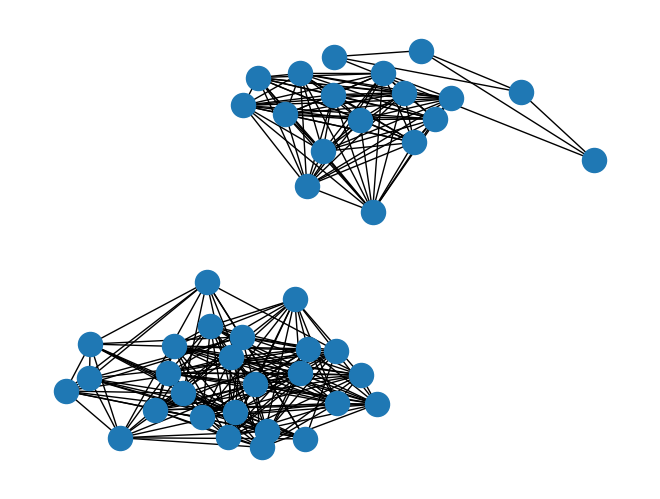

In [25]:
# https://stackoverflow.com/questions/14283341/how-to-increase-node-spacing-for-networkx-spring-layout
pos = nx.spring_layout(H, k=0.5, iterations=20)

nx.draw(H, pos=pos, with_labels=False)